# Collision Avoidance Fine Tunned VGG

Initial we load all the core libraries, and generate a random plot to check if matplot is working correctly.

Plotting Random histogram to check matplotlib


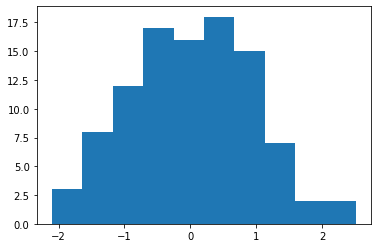

In [131]:
# %matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
print("Plotting Random histogram to check matplotlib")
plt.hist(np.random.randn(100))
plt.show()

Load additional libraries that are AI specific and configure tensorflow.

In [132]:
import PIL
import scipy
import pickle
import tensorflow as tf
print("Tensorflow version = " + tf.__version__ )
import os
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import model_from_json
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import time

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Tensorflow version = 2.2.0-dev20200311


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [133]:
# If you need to abort this session run the command
# session.close()

Configure directories paths:

In [134]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

### Helper-function for printing confusion matrix


In [135]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix


def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")

    # Print the confusion matrix as text.
    print(cm)

    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

### Helper-function for plotting example errors

Function for plotting examples of images from the test-set that have been mis-classified.


In [136]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])

    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]

    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function for generating and plotting example errors

Function for calculating the predicted classes of the entire test-set and calling the above function to plot a few examples of mis-classified images.

In [137]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()

    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred, axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)

    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

### Helper-function for loading images

The data-set is not loaded into memory, instead it has a list of the files for the images in the training-set and another list of the files for the images in the test-set. This helper-function loads some image-files.

In [138]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### Helper-function for plotting training history

This plots the classification accuracy and loss-values recorded during training with the Keras API.


In [139]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')

    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Dataset: Collision Avoidance

The Collision-avoidance dataset was introduced in Tutorial #09. It was generated from video-files by taking individual frames and converting them to images.

In [140]:
import dataset_ca

"""This dataset has another directory structure than the Keras API requires, so copy the files into separate directories for the training- and test-sets."""

# uncomment this linda is needed
# dataset_ca.copy_files()

'This dataset has another directory structure than the Keras API requires, so copy the files into separate directories for the training- and test-sets.'

The directories where the images are now stored.

In [141]:
train_dir = dataset_ca.train_dir
test_dir = dataset_ca.test_dir

## Load VGG Model

In [142]:
model = VGG16(include_top=True, weights='imagenet')

### Input Pipeline

The Keras API has its own way of creating the input pipeline for training a model using files.

First we need to know the shape of the tensors expected as input by the pre-trained VGG16 model. In this case it is images of shape 224 x 224 x 3.

In [143]:
input_shape = model.layers[0].output_shape[0][1:3]
input_shape

(224, 224)

Keras uses a so-called data-generator for inputting data into the neural network, which will loop over the data for eternity.

We have a small training-set so it helps to artificially inflate its size by making various transformations to the images. We use a built-in data-generator that can make these random transformations. This is also called an augmented dataset.


In [144]:
datagen_train = ImageDataGenerator(
    rescale=1. / 255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=[0.9, 1.1],
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

We also need a data-generator for the test-set, but this should not do any transformations to the images because we want to know the exact classification accuracy on those specific images. So we just rescale the pixel-values so they are between 0.0 and 1.0 because this is expected by the VGG16 model.

In [145]:
datagen_test = ImageDataGenerator(rescale=1. / 255)

The data-generators will return batches of images. Because the VGG16 model is so large, the batch-size cannot be too large, otherwise you will run out of RAM on the GPU.

In [146]:
batch_size = 20

We can save the randomly transformed images during training, so as to inspect whether they have been overly distorted, so we have to adjust the parameters for the data-generator above.

In [147]:
if True:
    save_to_dir = None
else:
    save_to_dir = 'augmented_images/'

Now we create the actual data-generator that will read files from disk, resize the images and return a random batch.

It is somewhat awkward that the construction of the data-generator is split into these two steps, but it is probably because there are different kinds of data-generators available for different data-types (images, text, etc.) and sources (memory or disk).

In [148]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 6008 images belonging to 2 classes.


The data-generator for the test-set should not transform and not shuffle the images.

In [149]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=True)

Found 156 images belonging to 2 classes.


Because the data-generators will loop for eternity, we need to specify the number of steps to perform during evaluation and prediction on the test-set. Because our test-set contains 530 images and the batch-size is set to 20, the number of steps is 26.5 for one full processing of the test-set. This is why we need to reset the data-generator's counter in the `example_errors()` function above, so it always starts processing from the beginning of the test-set.

This is another slightly awkward aspect of the Keras API which could perhaps be improved.


In [150]:
steps_test = generator_test.n / batch_size
steps_test

7.8

Get the file-paths for all the images in the training- and test-sets.

In [151]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

Get the class-numbers for all the images in the training- and test-sets.

In [152]:
cls_train = generator_train.classes
cls_test = generator_test.classes

Get the class-names for the dataset.

In [153]:
class_names = list(generator_train.class_indices.keys())
class_names

['collision', 'no_collision']

Get the number of classes for the dataset.

In [154]:
num_classes = generator_train.num_classes
num_classes

2

### Plot a few images to see if data is correct

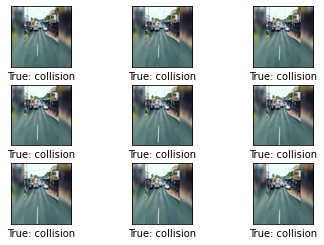

In [155]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[1000:1009])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

### Class Weights

The Collision Avoidance dataset is quite imbalanced because it has few images of collisions, more images of free flight. This can cause a problem during training because the neural network will be shown many more examples of free flight.

Here we use scikit-learn to calculate weights that will properly balance the dataset. These weights are applied to the gradient for each image in the batch during training, so as to scale their influence on the overall gradient for the batch.

In [156]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)
class_weight = {0:weights[0],1:weights[1]}

Note how the weight is about 1.98 for the collision-class and only 0.66 for the nocollision-class. This is because there are fewer images for the collision-class so the gradient should be amplified for those images, while the gradient should be lowered for nocollision-images.

In [157]:
print(class_weight)

print(class_names)

{0: 1.0, 1: 1.0}
['collision', 'no_collision']


## Example Predictions

Here we will show a few examples of using the pre-trained VGG16 model for prediction.

We need a helper-function for loading and resizing an image so it can be input to the VGG16 model, as well as doing the actual prediction and showing the result.

In [158]:
def predict_raw(input_model, image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = input_model.predict(img_array)
    print(pred)

In [159]:
def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array)

    # Decode the output of the VGG16 model.
    pred_decoded = decode_predictions(pred)[0]
    print(pred_decoded)

    # Print the predictions.
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

Weird results before training

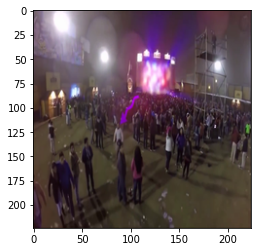

[('n04296562', 'stage', 0.4282363), ('n04418357', 'theater_curtain', 0.15316196), ('n04286575', 'spotlight', 0.14326033), ('n04456115', 'torch', 0.035886537), ('n03691459', 'loudspeaker', 0.027020104)]
42.82% : stage
15.32% : theater_curtain
14.33% : spotlight
 3.59% : torch
 2.70% : loudspeaker
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)       

In [160]:
predict(image_path='data/images/collision/colision1.mp4112.png')

model.summary()

We can see that the last convolutional layer is called 'block5_pool' so we use Keras to get a reference to that layer.

In [161]:
transfer_layer = model.get_layer('block5_pool')

We refer to this layer as the Transfer Layer because its output will be re-routed to our new fully-connected neural network which will do the classification for the Collision Avoidance dataset.

The output of the transfer layer has the following shape:

In [162]:
transfer_layer.output

<tf.Tensor 'block5_pool_2/Identity:0' shape=(None, 7, 7, 512) dtype=float32>

Using the Keras API it is very simple to create a new model. First we take the part of the VGG16 model from its input-layer to the output of the transfer-layer. We may call this the convolutional model, because it consists of all the convolutional layers from the VGG16 model.

In [163]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

We can then use Keras to build a new model on top of this.

In [164]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
conv_model._name = 'VGG16'
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

We use the Adam optimizer with a fairly low learning-rate. The learning-rate could perhaps be larger. But if you try and train more layers of the original VGG16 model, then the learning-rate should be quite low otherwise the pre-trained weights of the VGG16 model will be distorted and it will be unable to learn.

In [165]:
optimizer = Adam(lr=1e-5)

We have 2 classes in the Collision Avoidance dataset so Keras needs to use this loss-function.

In [166]:
mloss = 'categorical_crossentropy'

The only performance metric we are interested in is the classification accuracy.

In [167]:
metrics = ['categorical_accuracy']

Helper-function for printing whether a layer in the VGG16 model should be trained.

In [168]:
def print_layer_trainable():
    for layer in new_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

By default all the layers of the VGG16 model are trainable.

In [169]:
print("Before changing the trainable layers")
print_layer_trainable()

Before changing the trainable layers
True:	VGG16
True:	flatten_2
True:	dense_4
True:	dropout_2
True:	dense_5


In Transfer Learning we are initially only interested in reusing the pre-trained VGG16 model as it is, so we will disable training for all its layers.

In [170]:
conv_model.trainable = False

for layer in conv_model.layers:
    layer.trainable = False

print("After changing the trainable layers")
print_layer_trainable()

After changing the trainable layers
False:	VGG16
True:	flatten_2
True:	dense_4
True:	dropout_2
True:	dense_5


Once we have changed whether the model's layers are trainable, we need to compile the model for the changes to take effect.

In [171]:
new_model.compile(optimizer=optimizer, loss=mloss, metrics=metrics)
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VGG16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 2050      
Total params: 40,407,874
Trainable params: 25,693,186
Non-trainable params: 14,714,688
_________________________________________________________________


An epoch normally means one full processing of the training-set. But the data-generator that we created above, will produce batches of training-data for eternity. So we need to define the number of steps we want to run for each "epoch" and this number gets multiplied by the batch-size defined above. In this case we have 100 steps per epoch and a batch-size of 20, so the "epoch" consists of 2000 random images from the training-set. We run 20 such "epochs".

The reason these particular numbers were chosen, was because they seemed to be sufficient for training with this particular model and dataset, and it didn't take too much time, and resulted in 20 data-points (one for each "epoch") which can be plotted afterwards.

In [172]:
epochs = 20
steps_per_epoch = 100

Training the new model is just a single function call in the Keras API. This takes about 6-7 minutes on a GTX 1070 GPU.

In [173]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/20
100/100 [==============================] - 17s 168ms/step - loss: 0.6681 - categorical_accuracy: 0.6370 - val_loss: 0.5677 - val_categorical_accuracy: 0.6410
Epoch 2/20
100/100 [==============================] - 17s 168ms/step - loss: 0.5419 - categorical_accuracy: 0.7305 - val_loss: 0.5230 - val_categorical_accuracy: 0.6923
Epoch 3/20
100/100 [==============================] - 17s 168ms/step - loss: 0.4694 - categorical_accuracy: 0.7625 - val_loss: 0.4990 - val_categorical_accuracy: 0.7500
Epoch 4/20
100/100 [==============================] - 17s 168ms/step - loss: 0.4285 - categorical_accuracy: 0.7887 - val_loss: 0.5225 - val_categorical_accuracy: 0.6731
Epoch 5/20
100/100 [==============================] - 17s 169ms/step - loss: 0.3952 - categorical_accuracy: 0.8150 - val_loss: 0.4441 - val_categorical_accuracy: 0.7949
Epoch 6/20
100/100 [==============================] - 17s 168ms/step - loss: 0.3357 - categorical_accuracy: 0.8555 - val_loss: 0.4428 - val_categorical_acc

Keras records the performance metrics at the end of each "epoch" so they can be plotted later. This shows that the loss-value for the training-set generally decreased during training, but the loss-values for the test-set were a bit more erratic. Similarly, the classification accuracy generally improved on the training-set while it was a bit more erratic on the test-set.

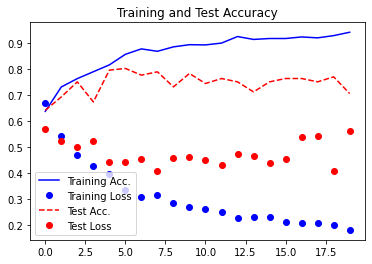

In [174]:
plot_training_history(history)

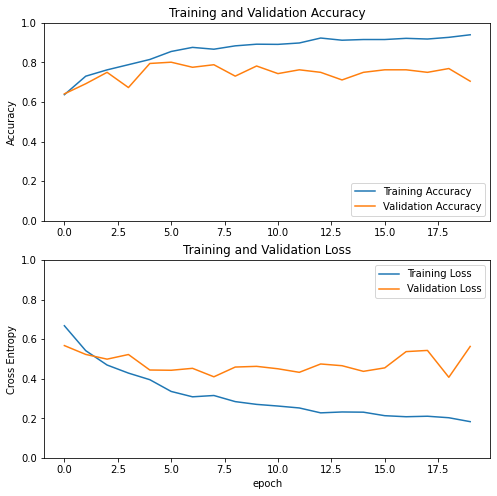

In [175]:
acc = history.history['categorical_accuracy']
loss = history.history['loss']

# Get it for the validation-set (we only use the test-set).
val_acc = history.history['val_categorical_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

After training we can also evaluate the new model's performance on the test-set using a single function call in the Keras API.

In [176]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 76.28%


We can plot some examples of mis-classified images from the test-set. Some of these images are also difficult for a human to classify.

The confusion matrix shows that the new model is especially having problems classifying the forky-class.

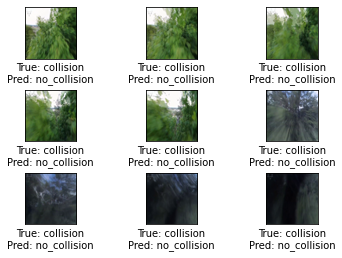

Confusion matrix:
[[28 50]
 [33 45]]
(0) collision
(1) no_collision


In [177]:
example_errors()

## Fine-Tuning

In Transfer Learning the original pre-trained model is locked or frozen during training of the new classifier. This ensures that the weights of the original VGG16 model will not change. One advantage of this, is that the training of the new classifier will not propagate large gradients back through the VGG16 model that may either distort its weights or cause overfitting to the new dataset.

But once the new classifier has been trained we can try and gently fine-tune some of the deeper layers in the VGG16 model as well. We call this Fine-Tuning.

It is a bit unclear whether Keras uses the `trainable` boolean in each layer of the original VGG16 model or if it is overrided by the `trainable` boolean in the "meta-layer" we call `conv_layer`. So we will enable the `trainable` boolean for both `conv_layer` and all the relevant layers in the original VGG16 model.

In [178]:
conv_model.trainable = True

We want to train the last two convolutional layers whose names contain 'block5' or 'block4'.

In [179]:
for layer in conv_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)

    # Set the layer's bool.
    layer.trainable = trainable

We can check that this has updated the `trainable` boolean for the relevant layers.

In [180]:
print_layer_trainable()

True:	VGG16
True:	flatten_2
True:	dense_4
True:	dropout_2
True:	dense_5


We will use a lower learning-rate for the fine-tuning so the weights of the original VGG16 model only get changed slowly.

In [181]:
optimizer_fine = Adam(lr=2e-8)

Because we have defined a new optimizer and have changed the `trainable` boolean for many of the layers in the model, we need to recompile the model so the changes can take effect before we continue training.

In [182]:
new_model.compile(optimizer=optimizer_fine, loss=mloss, metrics=metrics)

The training can then be continued so as to fine-tune the VGG16 model along with the new classifier.

In [183]:
initial_epochs = epochs
total_epochs =  initial_epochs + epochs
history = new_model.fit_generator(generator=generator_train,
                                  initial_epoch =  history.epoch[-1],
                                  epochs=total_epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 20/40
100/100 [==============================] - 17s 169ms/step - loss: 0.1867 - categorical_accuracy: 0.9350 - val_loss: 0.4552 - val_categorical_accuracy: 0.7628
Epoch 21/40
100/100 [==============================] - 17s 168ms/step - loss: 0.1726 - categorical_accuracy: 0.9396 - val_loss: 0.5015 - val_categorical_accuracy: 0.6987
Epoch 22/40
100/100 [==============================] - 17s 168ms/step - loss: 0.1770 - categorical_accuracy: 0.9390 - val_loss: 0.4301 - val_categorical_accuracy: 0.7564
Epoch 23/40
100/100 [==============================] - 17s 169ms/step - loss: 0.1739 - categorical_accuracy: 0.9420 - val_loss: 0.4660 - val_categorical_accuracy: 0.7308
Epoch 24/40
100/100 [==============================] - 17s 168ms/step - loss: 0.1641 - categorical_accuracy: 0.9472 - val_loss: 0.4841 - val_categorical_accuracy: 0.6859
Epoch 25/40
100/100 [==============================] - 17s 170ms/step - loss: 0.1718 - categorical_accuracy: 0.9405 - val_loss: 0.4419 - val_categoric

We can then plot the loss-values and classification accuracy from the training. Depending on the dataset, the original model, the new classifier, and hyper-parameters such as the learning-rate, this may improve the classification accuracies on both training- and test-set, or it may improve on the training-set but worsen it for the test-set in case of overfitting. It may require some experimentation with the parameters to get this right.

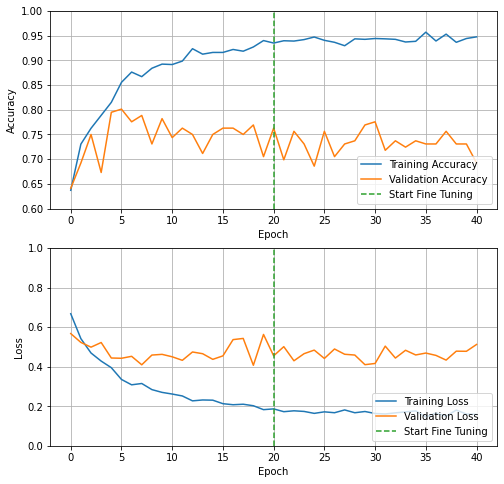

INFO:tensorflow:Assets written to: models/VGG-50.50-pervideo-ud-1588249002/assets


In [190]:
acc_f =  acc + history.history['categorical_accuracy']
val_acc_f = val_acc + history.history['val_categorical_accuracy']

loss_f = loss + history.history['loss']
val_loss_f = val_loss + history.history['val_loss']
fig= plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1).grid()
plt.plot(acc_f, label='Training Accuracy')
plt.plot(val_acc_f, label='Validation Accuracy')

plt.ylim([0.6, 1])
plt.plot([initial_epochs,initial_epochs],
          plt.ylim(), '--', label='Start Fine Tuning')
plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_f, label='Training Loss')
plt.plot(val_loss_f, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs,initial_epochs],
         plt.ylim(), '--', label='Start Fine Tuning')
plt.legend(loc='lower right')
#plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()
import time
NAME = f"VGG-50.50-pervideo-ud-{int(time.time())}"
#save graph
fig.savefig(f"/tf/notebooks/collision_avoidance/{NAME}.pdf", bbox_inches='tight')
# Save model
model.save("models/{}".format(NAME))

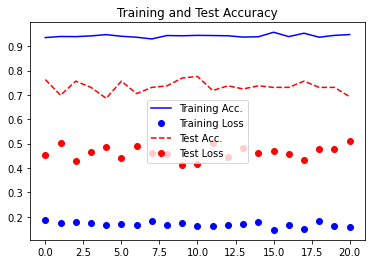

Test-set classification accuracy: 71.79%


In [185]:
plot_training_history(history)

result = new_model.evaluate_generator(generator_test, steps=steps_test)

print("Test-set classification accuracy: {0:.2%}".format(result[1]))

We can plot some examples of mis-classified images again, and we can also see from the confusion matrix that the model is still having problems classifying forks correctly.

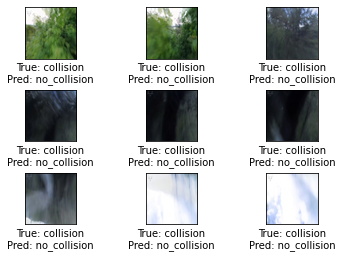

Confusion matrix:
[[36 42]
 [32 46]]
(0) collision
(1) no_collision


In [186]:
example_errors()

Save the last history for late work

In [187]:
with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    print("Saved history to disk!")

Saved history to disk!


Save the last model

In [188]:
# serialize model to JSON
model_json = new_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
new_model.save_weights("model.h5")
print("Saved model to disk!")

Saved model to disk!
